In [6]:
from datasets import load_dataset, DatasetDict, Dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="archive/sentiment_analysis.csv")
dataset

D:\anaconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 499 examples [00:00, 6930.71 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Year', 'Month', 'Day', 'Time of Tweet', 'text', 'sentiment', 'Platform'],
        num_rows: 499
    })
})

In [2]:
df = dataset["train"].to_pandas()
df["sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [3]:
df

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram
...,...,...,...,...,...,...,...
494,2015,10,18,night,"According to , a quarter of families under six...",negative,Twitter
495,2021,2,25,morning,the plan to not spend money is not going well,negative,Instagram
496,2022,5,30,noon,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,2018,8,10,night,congratulations ! you guys finish a month ear...,positive,Twitter


In [4]:
df.drop(columns=['Year', 'Month', 'Day', 'Time of Tweet', 'Platform'], inplace=True)
df

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative
...,...,...
494,"According to , a quarter of families under six...",negative
495,the plan to not spend money is not going well,negative
496,uploading all my bamboozle pictures of facebook,neutral
497,congratulations ! you guys finish a month ear...,positive


In [7]:
dataset = DatasetDict()
dataset["train"] = Dataset.from_pandas(df)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment'],
        num_rows: 499
    })
})

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["sentiment"])

In [9]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("sentiment")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 499
    })
})

In [10]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 399
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})

In [11]:
checkpoint = "MarieAngeA13/Sentiment-Analysis-BERT"

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

D:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\spase\.cache\huggingface\hub\models--MarieAngeA13--Sentiment-Analysis-BERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [13]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [14]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 9788.34 examples/s]


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=2,
    learning_rate=0.001,
    # report_to="none",
)

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [29]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.127665,0.238440
2,No log,1.079304,0.238440


D:\anaconda\Lib\site-packages\transformers\configuration_utils.py:393: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 64}
  warnings.warn(


TrainOutput(global_step=100, training_loss=1.1777464294433593, metrics={'train_runtime': 156.5762, 'train_samples_per_second': 5.097, 'train_steps_per_second': 0.639, 'total_flos': 13308811117812.0, 'train_loss': 1.1777464294433593, 'epoch': 2.0})

In [31]:
trainer.evaluate()

{'eval_loss': 1.0793037414550781,
 'eval_f1': 0.23843971631205674,
 'eval_runtime': 4.7871,
 'eval_samples_per_second': 20.889,
 'eval_steps_per_second': 2.716,
 'epoch': 2.0}

In [32]:
predictions = trainer.predict(tokenized_dataset["test"])

In [33]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.41      1.00      0.58        41
           2       0.00      0.00      0.00        36

    accuracy                           0.41       100
   macro avg       0.14      0.33      0.19       100
weighted avg       0.17      0.41      0.24       100



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix')

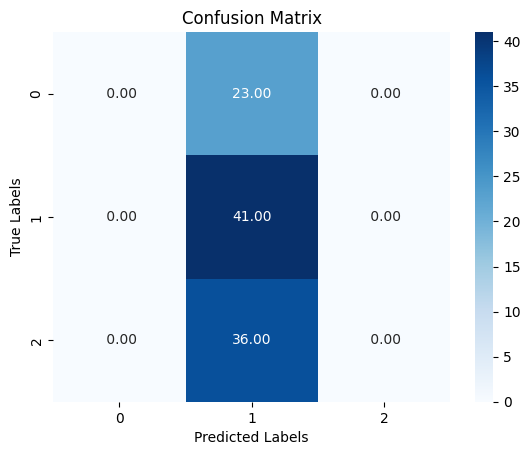

In [36]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [79]:
df = pd.read_csv("archive/sentiment_analysis.csv")
df

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram
...,...,...,...,...,...,...,...
494,2015,10,18,night,"According to , a quarter of families under six...",negative,Twitter
495,2021,2,25,morning,the plan to not spend money is not going well,negative,Instagram
496,2022,5,30,noon,uploading all my bamboozle pictures of facebook,neutral,Facebook
497,2018,8,10,night,congratulations ! you guys finish a month ear...,positive,Twitter


In [80]:
df.drop(columns=['Year', 'Month', 'Day', 'Time of Tweet', 'Platform'], inplace=True)
df

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative
...,...,...
494,"According to , a quarter of families under six...",negative
495,the plan to not spend money is not going well,negative
496,uploading all my bamboozle pictures of facebook,neutral
497,congratulations ! you guys finish a month ear...,positive


<Axes: xlabel='sentiment'>

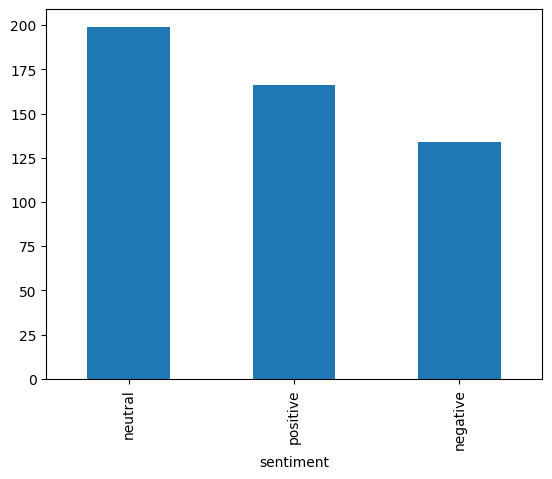

In [81]:
df["sentiment"].value_counts().plot.bar()

In [82]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

<Axes: ylabel='Frequency'>

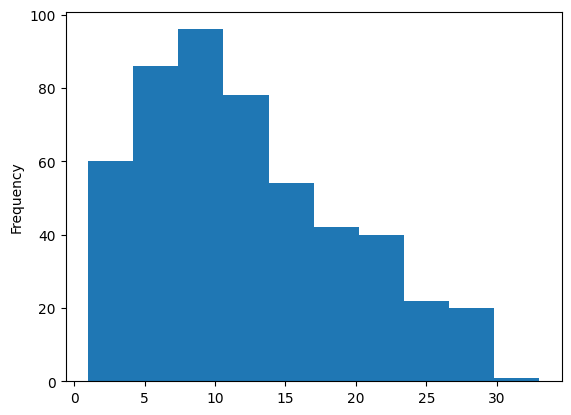

In [83]:
df["text"].str.split(" ").apply(len).plot.hist()

<Axes: >

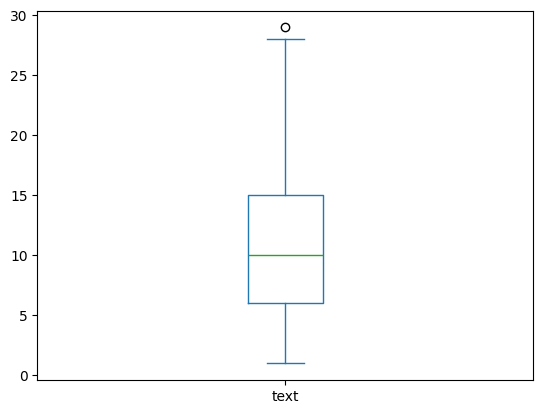

In [84]:
df["text"].str.split().apply(len).plot.box()

In [85]:
df = df[df["text"].str.split().apply(len) < 27].copy(deep=True)
df

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative
...,...,...
494,"According to , a quarter of families under six...",negative
495,the plan to not spend money is not going well,negative
496,uploading all my bamboozle pictures of facebook,neutral
497,congratulations ! you guys finish a month ear...,positive


<Axes: ylabel='Frequency'>

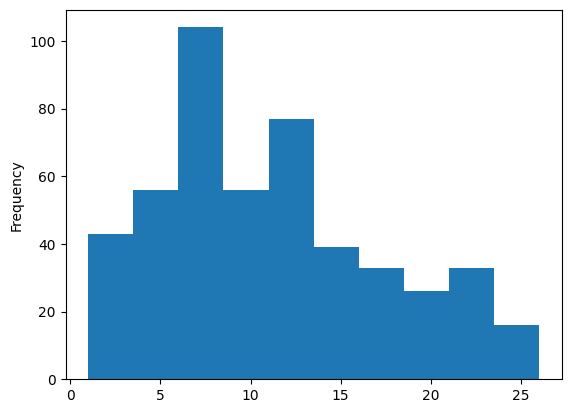

In [86]:

df["text"].str.split().apply(len).plot.hist()

<Axes: >

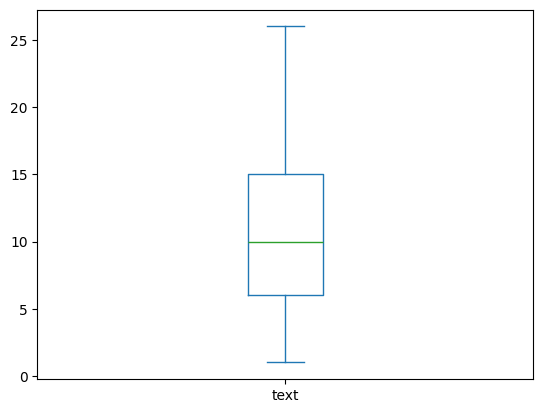

In [87]:
df["text"].str.split().apply(len).plot.box()

In [88]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [89]:
vocabulary = get_vocabulary(df["text"].tolist())

In [90]:
len(vocabulary)

1789

In [91]:
max_vocabulary_size = 1600

In [92]:
X, y = df["text"], pd.get_dummies(df["sentiment"])

In [93]:
y.head()

,negative,neutral,positive
0,False,False,True
1,False,False,True
2,True,False,False
3,True,False,False
4,True,False,False


In [94]:
num_classes = y.shape[1]
num_classes

3

In [95]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [96]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

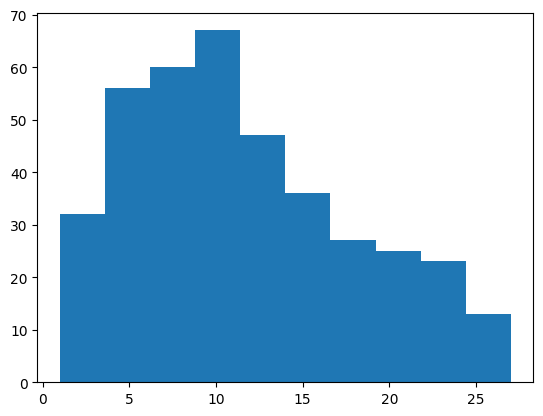

In [97]:
plt.hist([len(tokens) for tokens in train_X]);

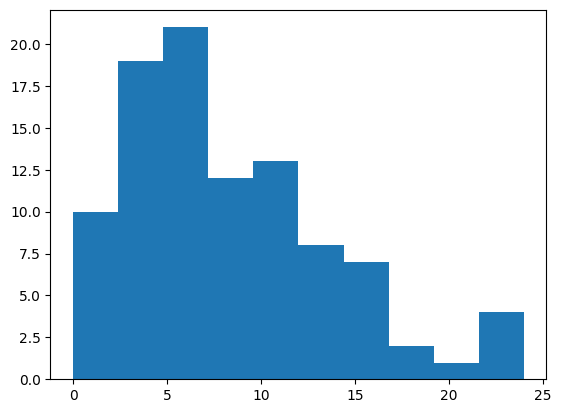

In [98]:
plt.hist([len(tokens) for tokens in test_X]);

In [99]:
maxlen = 17

In [100]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [101]:
train_X.shape, test_X.shape

((386, 17), (97, 17))

In [102]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [103]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [104]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=20)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - f1_score: 0.1937 - loss: 1.0976 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.1982 - val_loss: 1.0854 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - f1_score: 0.1819 - loss: 1.0882 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.1982 - val_loss: 1.0718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - f1_score: 0.1819 - loss: 1.0801 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.1982 - val_loss: 1.0588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - f1_score: 0.1819 - loss: 1.0743 - precision: 0.3485 - recall: 0.0093 - val_f1_score: 0.1982 - val_loss: 1.0523 - val_precision: 0.5000 - val_recall: 0.0385
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - f1_score: 0.1819 - loss: 1.0622 - precision: 0.5681 - recall: 0.0646 - v

In [105]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 17, 32)              │          51,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 17, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,067 (941.67 KB)

 Trainable params: 80,355 (313.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,712 (627.79 KB)

<Axes: >

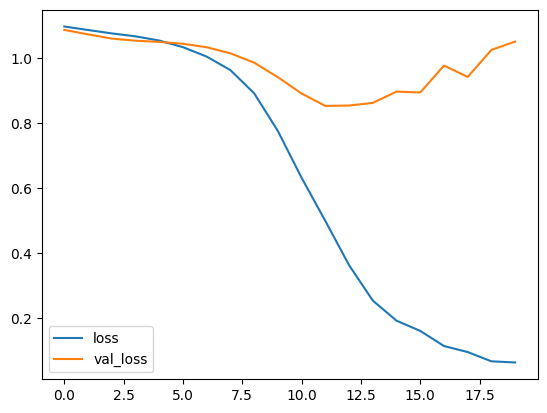

In [106]:

sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [107]:
preds = model.predict(test_X)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F4FA3C68E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [108]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [109]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.55      0.46      0.50        24
           1       0.53      0.72      0.61        36
           2       0.71      0.54      0.62        37

    accuracy                           0.59        97
   macro avg       0.60      0.57      0.58        97
weighted avg       0.61      0.59      0.59        97

